# LSTM Geometric Brownian Motion: Live BTC Data Prediction

Most extensions of the GBM SDE are based on a stochastic volatility model, where the volatility is not constant but instead follows a geometric brownian itself. To focus on the general ansatz the SDE can be extended to 

\begin{align*}
dS_t = \mu S_t + \nu_t S_t dW_t
\end{align*}

where $\nu_t$ denotes the time-dependent volatility. At this level of generalization the following thesis is raised, whether the drift $\mu$ can vary as well. Similar to the approach of <strong>stochastic volatility</strong>. The time dependence of GBM parameters relies on the pragmatic idea to apply the same modelling on generator level, where the combination of $\mu$ and $\sigma$ acts as the generating moment $\frac{d S}{d t}$ and can be calculated with Itô's general solution.

Assuming that the vectors $\nu(t) \equiv \nu_t$ and $\mu(t)$ could be approximated accurately enough (at least in the mean), to increase the sampling efficiency due to better price direction sampling and also would make methods like selection of specific path generations (which suite the conjectured continuation from other methods e.g. by discarding generations which do not respect linear regression) obsolete. Also the time-resolved volatility allows to model uncertainty regimes over time.

Further the model can also be extended by a self-studied method, randomly called "intrinsic geometric brownian motion", which exploits the method of sampling from an intrinsic log return distribution accounted from data instead of sampling from a standard normal (like in GBM). When the expected mean drift $\mu=\left\langle log \left (  R \right ) \right\rangle_a$ is subtracted from the distribution and devided by the meaned volatility $\sigma$ then the obtained distribution should be "similar" to a standard normal distribution $\sim \mathcal{N}(0,1)$ and thus an unbiased estimator. The assumption that the mean is zero arises from the central limit theorem, and is actually biased by the standard error $1/\sqrt{n}$, so for a large enough data sample the bias should converge sufficiently to zero. The newly derived distribution yields the "sampled wiener distribution" which can be exploited for better (biased to the data, and less generic) sampling of randomness. This will allow to model specific (data-suited) return patterns for more seamless generations, since specific wiener increments which were not obsereved in the input data are prohibited for sampling by this method, whereas a gaussian simply assumes a smoothly interpolated non-zero value and underestimates edge-tail events, which are non-negligible and can be proven from the data. Increments obtained (sampled) from the sampled wiener distribution are denoted by $d\tilde{W}_t$. The newly improved differential equation can be written as


\begin{align*}
dS_t = \mu_t S_t + \nu_t S_t d\tilde{W}_t
\end{align*}

The parameters can be estimated with a LSTM RNN prediction. With sufficient smoothing for a sufficiecnt mean approximation for $\mu, \sigma$ the LSTM with $\sim 20$ epochs of single-batch training converges in it's standard mean error to sufficiently good fits - the method is often helpful to estimate the approximated evolutions which should improve the determinacy of the SDE samples. Thus, rather than a completely generic MC generation, based on constant parameters and a standard normal wiener process, the improced SDE will be biased in the most expected direction and the volatility will obey the intrisic distribution. For small enough time steps (prediction data points). Since the LSTM is uniquely fitted to the problem at hand, at these epoch sizes overfitting the model to the finite input will result in a more conservative prediction and focuses to predict based to replicate the test data. Otherwise for small epoch sizes the prediction will yield more generic predictions i.e. less biased by the input pattern.

# Prepare Data (request from API)

In [4]:
from chartpeer.loader import krakenApi, load
from chartpeer.extrapolate import lstm_gbm
from chartpeer.analysis import plot

# load ohlc and convert to closed prices
ohlc = krakenApi.ohlc('BTC', 60)
closed = load.closedFromOhlc(ohlc)[-365:]

## Test Prediction Efficiency with Recent Data

Epoch 1/15
272/272 [==============================] - 6s 15ms/step - loss: 0.0251
Epoch 2/15
272/272 [==============================] - 4s 14ms/step - loss: 0.0226
Epoch 3/15
272/272 [==============================] - 4s 14ms/step - loss: 0.0219
Epoch 4/15
272/272 [==============================] - 4s 14ms/step - loss: 0.0213
Epoch 5/15
272/272 [==============================] - 4s 14ms/step - loss: 0.0212
Epoch 6/15
272/272 [==============================] - 4s 14ms/step - loss: 0.0210
Epoch 7/15
272/272 [==============================] - 4s 14ms/step - loss: 0.0203
Epoch 8/15
272/272 [==============================] - 4s 15ms/step - loss: 0.0204
Epoch 9/15
272/272 [==============================] - 4s 15ms/step - loss: 0.0200
Epoch 10/15
272/272 [==============================] - 4s 15ms/step - loss: 0.0196
Epoch 11/15
272/272 [==============================] - 4s 15ms/step - loss: 0.0186
Epoch 12/15
272/272 [==============================] - 4s 15ms/step - loss: 0.0192
Epoch 13/15
2

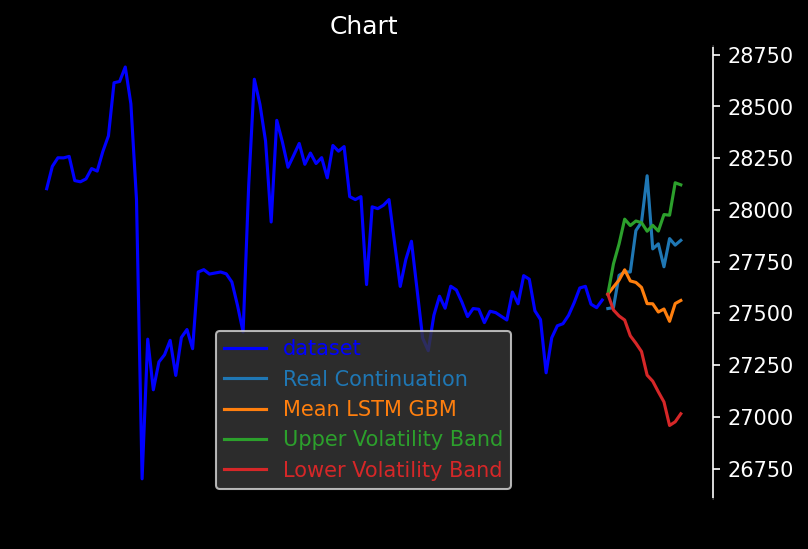

In [5]:
# predict for 14 intervals of e.g. minutes, hours, days etc.
feature_length = 14

# split into Input (for training) and target set
Input = closed[:-feature_length]
target = closed[-feature_length:]

output = lstm_gbm(Input, feature_length, epochs=(15,10), smoothing=5)

plot.chart(Input[-100:], predictionSets = {
    'Real Continuation': target,
    'Mean LSTM GBM': output['mean'],
    'Upper Volatility Band': output['upper'],
    'Lower Volatility Band': output['lower']
})

## BTC Live Prediction

In [ ]:
# predict for 14 intervals of e.g. minutes, hours, days etc.
feature_length = 14

# start training with subsequent prediction of full recent dataset
output = lstm_gbm(closed, feature_length, epochs=(15,10), smoothing=5)